# Surface concentrations

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import netCDF4 as nc
from itertools import compress
import datetime as dt
from datetime import date
import matplotlib.backends.backend_pdf

%matplotlib notebook

###### Parameters:

In [3]:
imin, imax = 1480, 2180
jmin, jmax = 160, 800
isize = imax - imin
jsize = jmax - jmin

land_color = '#8b7765'

# model results:
year = 2015

base_old    = '/data/brogalla/run_storage/Mn-set4-202004/'
base_tuning = '/data/brogalla/run_storage/Mn-tuning-202012/'

old       = base_old + 'ref-2015/'
tuning    = base_tuning + 'ref-2015-tuning5/'

In [4]:
stn_i = np.array([104-1, 100, 91, 175, 175, 233, 214, 352, 242, 458, 508, 547, 629])
stn_j = np.array([370, 365, 353, 311, 326, 313, 281, 281, 364, 332, 384, 457, 471])
stn_n = np.array(['CAA1','CAA2','CAA3','CAA4','CAA5','CAA6','CAA7',
                  'CAA8','CAA9', 'CB1','CB2','CB3','CB4'])

###### Load files:

In [5]:
mask      = nc.Dataset('/ocean/brogalla/GEOTRACES/ariane_runs/ANHA12_Ariane_mesh.nc')
tmask     = np.array(mask.variables['tmask'])[0,:,imin:imax,jmin:jmax]
land_mask = np.ma.masked_where((tmask[:,:,:] > 0.1), tmask[:,:,:]) 

In [6]:
ref   = nc.Dataset(old+'ANHA12_EXH006_'+str(year)+'_monthly.nc',  'r')
lons  = np.array(ref.variables['nav_lon'])
lats  = np.array(ref.variables['nav_lat'])
depth = np.array(ref.variables['deptht'])
dissolmn_old = np.array(ref.variables['dissolmn'][:,0,:,:,:])*10**9 # nM units
oxidismn_old = np.array(ref.variables['oxidismn'][:,0,:,:,:])*10**9 # nM units
ref.close()

In [7]:
results      = nc.Dataset(tuning+'ANHA12_EXH006_'+str(year)+'_monthly.nc')
dissolmn_new = np.array(results.variables['dissolmn'][:,0,:,:,:])*10**9 # nM units
oxidismn_new = np.array(results.variables['oxidismn'][:,0,:,:,:])*10**9 # nM units
results.close()

In [8]:
mask      = nc.Dataset('/ocean/brogalla/GEOTRACES/ariane_runs/ANHA12_Ariane_mesh.nc')
tmask     = np.array(mask.variables['tmask'])[0,:,imin:imax,jmin:jmax]
land_mask = np.ma.masked_where((tmask[:,:,:] > 0.1), tmask[:,:,:]) 

e1t_base = np.array(mask.variables['e1t'])[0,imin:imax,jmin:jmax]
e2t_base = np.array(mask.variables['e2t'])[0,imin:imax,jmin:jmax]
e3t      = np.array(mask.variables['e3t_0'])[0,:,imin:imax,jmin:jmax]

e1t      = np.tile(e1t_base, (50,1,1))
e2t      = np.tile(e2t_base, (50,1,1))
volume   = e1t*e2t*e3t

##### Functions:

In [12]:
def plot_layer(month, layer, variable, vmin=0,vmax=35, savefig=False):
    
    fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/mn-reference.pickle','rb'))

    x, y = proj1(lons, lats)

    contour = proj1.contourf(x, y, variable[month,layer,:,:], 20,\
                             cmap=cmocean.cm.dense, vmin=vmin, vmax=vmax, extend='both')

    cbar_ax = fig.add_axes([0.73, 0.16, 0.05, 0.6])
    cbar    = fig.colorbar(contour, cax=cbar_ax, ticks=[0,5,10,15,20,25,30])
    cbar.set_label('Dissolved Mn [nM]', fontsize=13) 
    cbar_ax.tick_params(axis='both', which='major', labelsize=13)
    
    return

In [13]:
def load_results(folder_ref):
    
    months  = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
    dmn_riv = np.empty((12,1,isize,jsize))   ; dmn_sed = np.empty((12,1,isize,jsize)); 
    dmn_atm = np.empty((12,1,isize,jsize))   ; dmn_ice = np.empty((12,1,isize,jsize));
    dmn_sedice = np.empty((12,1,isize,jsize));
    dmn_red = np.empty((12,50,isize,jsize)); dmn_oxi = np.empty((12,50,isize,jsize))
    
    i=0
    for month in months:
        file        = 'ANHA12_EXH006_1m_'+str(year)+'0101_'+str(year)+'1231_comp_'+str(year)+month+'-'+str(year)+month+'.nc'
        ref_monthly = nc.Dataset(folder_ref+file)
        
        dmn_riv[i,0,:,:]    = np.array(ref_monthly.variables['dmnriv'])[0,:,:]*(10**9)*(3600*24*31)
        dmn_sed[i,0,:,:]    = np.array(ref_monthly.variables['dmnsed'])[0,:,:]*(10**9)*(3600*24*31)
        dmn_sedice[i,0,:,:] = np.array(ref_monthly.variables['dmnsedice'])[0,:,:]*(10**9)*(3600*24*31)
        dmn_atm[i,0,:,:]    = np.array(ref_monthly.variables['dmnatm'])[0,:,:]*(10**9)*(3600*24*31)
        dmn_ice[i,0,:,:]    = np.array(ref_monthly.variables['dmnice'])[0,:,:]*(10**9)*(3600*24*31)
        dmn_red[i,:,:,:]  = np.array(ref_monthly.variables['dmnred'])[0,:,:,:]*(10**9)*(3600*24*31)
        dmn_oxi[i,:,:,:]  = np.array(ref_monthly.variables['dmnoxi'])[0,:,:,:]*(10**9)*(3600*24*31)
        i+=1
    
    tmask_surf    = np.empty(dmn_riv.shape)
    tmask_surf[:] = tmask[0,:,:]
    tmask_full    = np.empty(dmn_red.shape)
    tmask_full[:] = tmask
    
    # Mask points on land:
    dmn_mriv    = np.ma.masked_where((tmask_surf < 0.1), dmn_riv); 
    dmn_msed    = np.ma.masked_where((tmask_surf < 0.1), dmn_sed)
    dmn_msedice = np.ma.masked_where((tmask_surf < 0.1), dmn_sedice)
    dmn_matm    = np.ma.masked_where((tmask_surf < 0.1), dmn_atm)
    dmn_mice    = np.ma.masked_where((tmask_surf < 0.1), dmn_ice)
    dmn_mred    = np.ma.masked_where((tmask_full < 0.1), dmn_red)
    dmn_moxi    = np.ma.masked_where((tmask_full < 0.1), dmn_oxi)

    return dmn_mriv, dmn_msed, dmn_msedice, dmn_matm, dmn_mice, dmn_mred , dmn_moxi

In [14]:
def plot_experiment(ax, variable, month=0, layer=0, vmin=0, vmax=7, cmap=cmocean.cm.dense):
    proj1 = Basemap(projection='stere',lat_0 = 77.1, lon_0 = -85, resolution='i', width=4.5e6, height=2.98e6, ax=ax)
    # proj1.drawcoastlines(color='#373736', linewidth=1.8)
    proj1.fillcontinents(color=land_color, lake_color=land_color, zorder=5);
    x, y = proj1(lons, lats)
    
    c1 = proj1.contourf(x, y, variable[month,layer,:,:], np.arange(vmin,vmax+1,0.25),\
                             cmap=cmap, vmin=vmin, vmax=vmax, extend='both')
    
    return c1

##### Figures of surface concentrations:

<IPython.core.display.Javascript object>


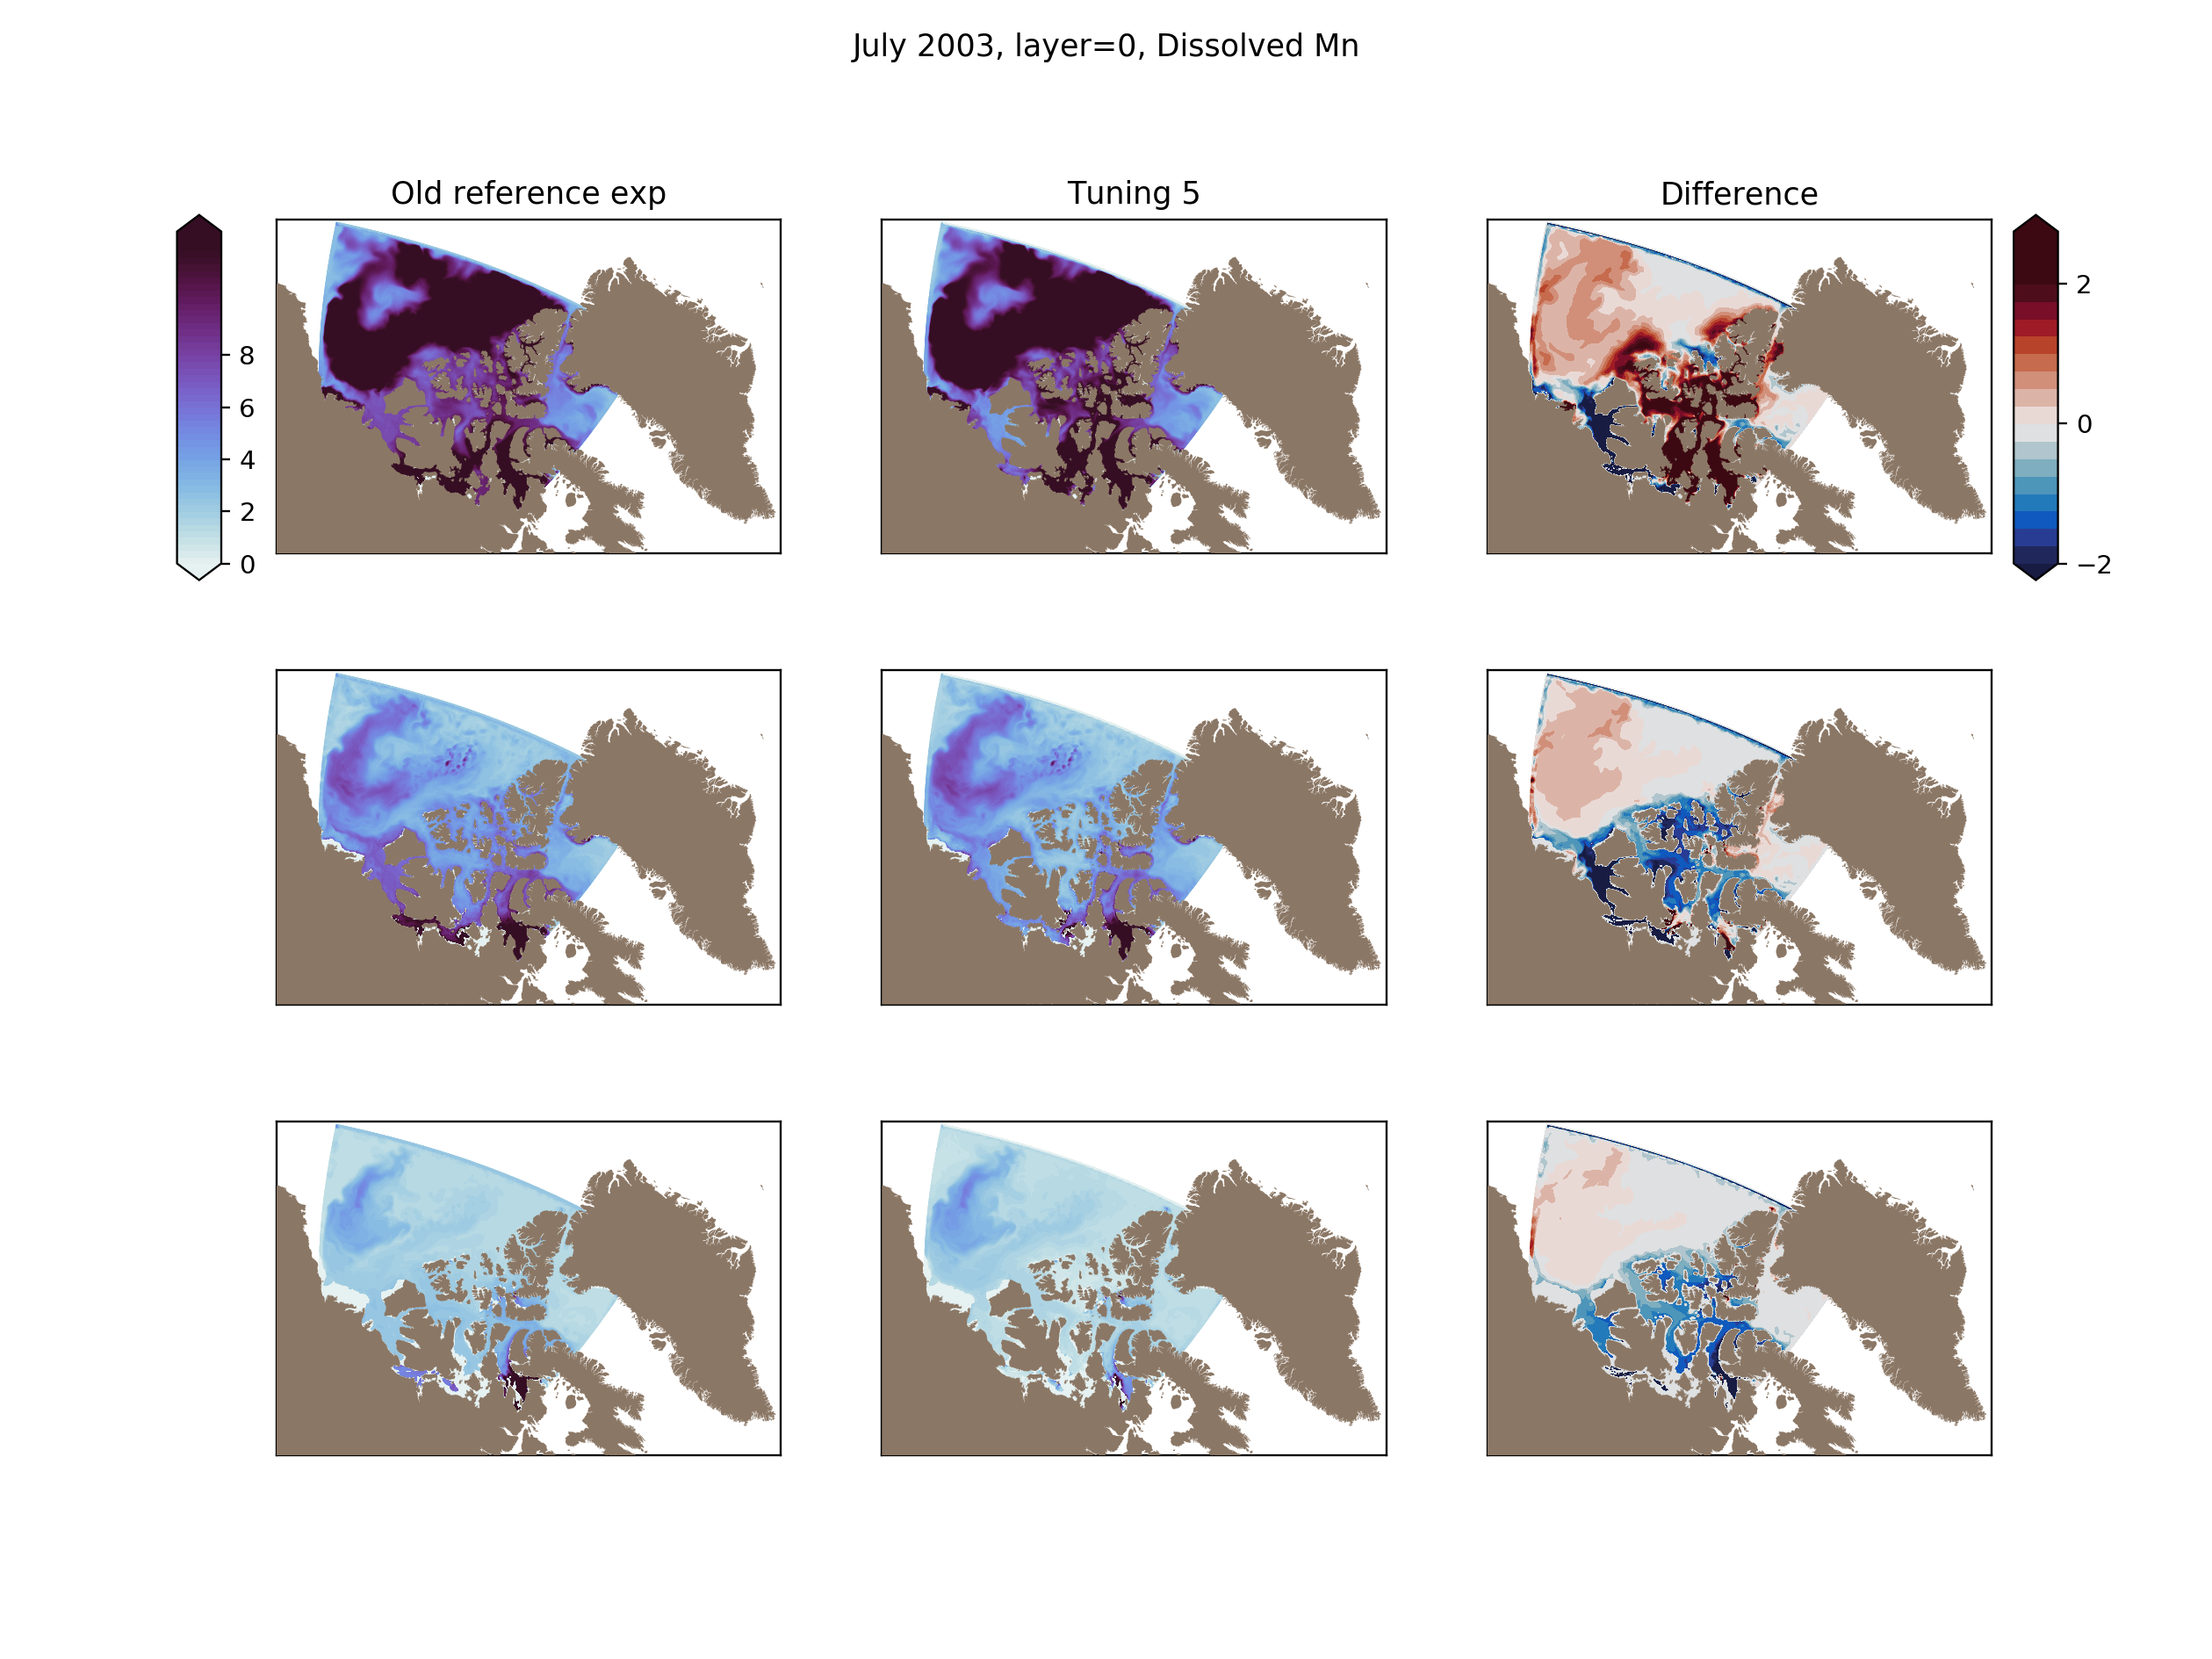

/home/brogalla/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  


In [16]:
month=7;
#----------------------------------------------------------------------------
fig3, ax = plt.subplots(3,3, figsize=(12,9))

fig3.suptitle('July 2003, layer=0, Dissolved Mn')

# Panel A & B: 
c1 = plot_experiment(ax[0,0], dissolmn_old, vmax=12, month=month, layer=0)
c2 = plot_experiment(ax[0,1], dissolmn_new, vmax=12, month=month, layer=0)
c3 = plot_experiment(ax[0,2], dissolmn_new-dissolmn_old, vmin=-2, vmax=2, \
                     cmap=cmocean.cm.balance, month=month, layer=0)
ax[0,0].set_title('Old reference exp')
ax[0,1].set_title('Tuning 5')
ax[0,2].set_title('Difference')

# Panel C & D: 
c4 = plot_experiment(ax[1,0], dissolmn_old, vmax=12, month=month, layer=10)
c5 = plot_experiment(ax[1,1], dissolmn_new, vmax=12, month=month, layer=10)
c6 = plot_experiment(ax[1,2], dissolmn_new-dissolmn_old, vmin=-2, vmax=2, \
                     cmap=cmocean.cm.balance, month=month, layer=10)

# Panel E & F: 
c7 = plot_experiment(ax[2,0], dissolmn_old, vmax=12, month=month, layer=20)
c8 = plot_experiment(ax[2,1], dissolmn_new, vmax=12, month=month, layer=20)
c9 = plot_experiment(ax[2,2], dissolmn_new-dissolmn_old, vmin=-2, vmax=2, \
                     cmap=cmocean.cm.balance, month=month, layer=20)

cbar_ax1 = fig3.add_axes([0.08, 0.65, 0.02, 0.22])
cbar_ax2 = fig3.add_axes([0.91, 0.65, 0.02, 0.22])
cbar1    = fig3.colorbar(c1, cax=cbar_ax1, ticks=[0, 2, 4, 6, 8])
cbar2    = fig3.colorbar(c3, cax=cbar_ax2, ticks=[-8, -6, -4, -2, 0, 2, 4, 6, 8])

In [96]:
pdf = matplotlib.backends.backend_pdf.PdfPages("/ocean/brogalla/GEOTRACES/figures/experiments-20201201.pdf")
pdf.savefig(fig1)
pdf.savefig(fig2)
pdf.savefig(fig3)
pdf.close()